<a href="https://colab.research.google.com/github/zd341/Author-Authentication/blob/main/Model_Testing_Authorship_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUTHORSHIP AUTHENTICATION

# BUSINESS UNDERSTANDING

**To Do**

*   Balance Philosophers Dataset and Run models
*   Clean Twitter Dataset
*   GridCV for all models
*   Tidy Notebook
*   for LSTM, BI-LSTM, GRU & CNN
*   Start Pre-processing and Modelling Twitter Data
*   Run Random Forest Classifier, XGBoost










### Configuring Google Drive and Checking GPU Collab Notebook

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Thu Aug 26 13:31:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    37W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA UNDERSTANDING PHASE- PHILOSOPHERS TEXT

## Importing and Checking Data

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/data/sentences.csv')

In [6]:
df.head(3)

,label,sentence,author,word_count,mean_word_length,stop_words_ratio,stop_words_count,ADJ_count,ADV_count,ADP_count,AUX_count,DET_count,NUM_count,X_count,INTJ_count,CONJ_count,CCONJ_count,SCONJ_count,PROPN_count,NOUN_count,PRON_count,PART_count,VERB_count
0,0,We may call the faculty of cognition from prin...,Kant,64,5.20,56.25,36,6,2,11,0,11,0,1,0,0,2,3,0,17,3,1,7
1,0,That goes merely into our faculty of knowing t...,Kant,82,5.13,57.32,47,5,4,14,1,14,0,3,0,0,6,2,3,17,4,0,9
2,0,"The Critique, then, which sifts them all, as r...",Kant,50,4.84,62.00,31,4,1,6,1,12,0,1,0,0,1,3,1,10,3,1,6


In [7]:
df_n = df.iloc[:,:3]

df_n.head()

,label,sentence,author
0,0,We may call the faculty of cognition from prin...,Kant
1,0,That goes merely into our faculty of knowing t...,Kant
2,0,"The Critique, then, which sifts them all, as r...",Kant
3,0,It relegates all other pure concepts under Ide...,Kant
4,0,For they serve as regulative principles; partl...,Kant


In [8]:
print(df['label'].unique())

print(df['author'].unique())

philo_list = ['Kant', 'Hume', 'Plato', 'Aristotle','Nietzsche']


[0 1 2 3 4]
['Kant' 'Hume' 'Plato' 'Aristotle' 'Nietzsche']


In [9]:
df_n.shape

(107134, 3)

## Stratified Sampling

In [10]:
df_n['author'].value_counts()

Hume         45328
Plato        19741
Nietzsche    18589
Kant         13288
Aristotle    10188
Name: author, dtype: int64

In [11]:
(df['author'].value_counts() / len(df)).sort_values(ascending=False)

Hume         0.423096
Plato        0.184265
Nietzsche    0.173512
Kant         0.124032
Aristotle    0.095096
Name: author, dtype: float64

In [12]:
def stratify_data(df_data, stratify_col_name, stratify_val, stratify_prop, random_state=None):
    """
    Returns:
        DataFrame: a new dataframe based the new proportions represnting the desired stratification strategy
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data

    pos = -1
    for i in range(len(stratify_val)): # iterate over the stratify values (e.g. "Male, Undergraduate" etc.)
        pos += 1
        if pos == len(stratify_val) - 1: 
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_prop[i]) # Calculate the number of rows to match the desired proportion

        df_filtered = df_data[df_data[stratify_col_name] ==stratify_val[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
        
    return df_stratified # Return the stratified, re-sampled data  

In [13]:
stratify_values = philo_list
stratify_proportions = [0.20, 0.20, 0.20, 0.20,0.20]
df_stratified = stratify_data(df_n, 'author', stratify_values, stratify_proportions, random_state=42)
df_stratified

,label,sentence,author
7270,0,"Now every change has a cause, which evidences ...",Kant
860,0,the presupposition of the moral feeling in man.,Kant
5390,0,"For if, on the one hand, we place them in pure...",Kant
5191,0,Now it is clear from the Analytic that the max...,Kant
11964,0,The federation of Europe will follow the feder...,Kant
...,...,...,...
102862,4,Wherever the Olympian gods receded into the ba...,Nietzsche
97690,4,"To be sure, I love in him the shoulders of the...",Nietzsche
102902,4,126 Art and Strength of False Interpretation.-...,Nietzsche
98362,4,Art thou not the light of my fire?,Nietzsche


In [14]:
(df_stratified['author'].value_counts() / len(df)).sort_values(ascending=False)

Nietzsche    0.200030
Hume         0.199993
Aristotle    0.199993
Plato        0.199993
Kant         0.199993
Name: author, dtype: float64

# DATA PREPARATION PHASE - PHILOSOPHERS TEXT

In [15]:

# Import Natural Language Processing Libraries
import nltk
import re
import string

# nlp = spacy.load('en_core_web_sm')

In [16]:
df_stratified.isnull().sum()

label       0
sentence    0
author      0
dtype: int64

In [17]:
sent = df_stratified['sentence'][0]

sent

'We may call the faculty of cognition from principles a priori, pure Reason, and the inquiry into its possibility and bounds generally the Critique of pure Reason, although by this faculty we only understand Reason in its theoretical employment, as it appears under that name in the former work; without wishing to inquire into its faculty, as practical Reason, according to its special principles.'

In [18]:
df_stratified['abrev_auth']= df_stratified['author'].apply(lambda abrev: 'KNT' if abrev == 'Kant' 
                                         else 'HUM' if abrev == 'Hume' 
                                         else 'PLT' if abrev == 'Plato' 
                                         else 'ALE' if abrev =='Aristotle' 
                                         else 'NZE')


df_stratified["abrev_auth"].unique()

array(['KNT', 'HUM', 'PLT', 'ALE', 'NZE'], dtype=object)

In [19]:
# Remove all Capitalisation

df_stratified['lower_sentence']= df_stratified['sentence'].apply(lambda s: s.lower())

df_stratified['lower_sentence'][0]

'we may call the faculty of cognition from principles a priori, pure reason, and the inquiry into its possibility and bounds generally the critique of pure reason, although by this faculty we only understand reason in its theoretical employment, as it appears under that name in the former work; without wishing to inquire into its faculty, as practical reason, according to its special principles.'

In [20]:
df_stratified["abrev_auth"].unique()

# Deleting the author column
del df_stratified['author'] 

# Re-ordering columns in dataframe
df_stratified = df_stratified[["label", "abrev_auth", "sentence","lower_sentence"]]

# Rename Columns
df_stratified.rename(inplace=True,columns={"abrev_auth":"author"})


In [21]:
del df_stratified['sentence']


df_stratified.rename(inplace=True,columns={"lower_sentence":"sentence"})

In [22]:
df_stratified.head()

,label,author,sentence
7270,0,KNT,"now every change has a cause, which evidences ..."
860,0,KNT,the presupposition of the moral feeling in man.
5390,0,KNT,"for if, on the one hand, we place them in pure..."
5191,0,KNT,now it is clear from the analytic that the max...
11964,0,KNT,the federation of europe will follow the feder...


In [23]:

# def remove_punct(text):
#   table = str.maketrans("","", string.punctuation)
#   return text.translate(table)


# df_stratified['sentence']= df_stratified.sentence.map(lambda x: remove_punct(x))


# df_stratified.head()

In [24]:

# from nltk.corpus import stopwords
# nltk.download("stopwords", quiet=True)

# sw = set(stopwords.words('english'))

# def remove_stop_words(text):
#   text = [word.lower() for word in text.split() if word.lower() not in sw ]

#   return " ".join(text)


# df_stratified['sentence'] =   df_stratified['sentence'].map(remove_stop_words)

# df_stratified.head()

In [25]:
df_stratified.sentence[:3]

7270    now every change has a cause, which evidences ...
860       the presupposition of the moral feeling in man.
5390    for if, on the one hand, we place them in pure...
Name: sentence, dtype: object

# EXPOLORATORY DATA ANALYSIS - PHILOSOPHERS TEXTS 

In [26]:
# Importing data visualisation Libraries 
import matplotlib.pyplot as plt 
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Bar Plot Word Count per Author

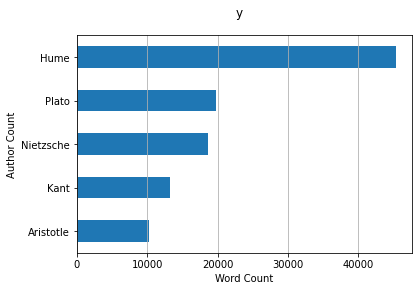

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_n['author'].reset_index().groupby("author").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.xlabel('Word Count')
plt.ylabel('Author Count')
plt.show()


## Density plot of Word Count per Author

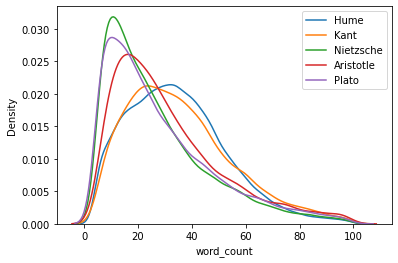

In [ ]:

# bins =1.15 **(np.arange(0,35))
sns.kdeplot(df[df['author']=='Hume']['word_count'], alpha= 0.5,gridsize=200)
sns.kdeplot(df[df['author']=='Kant']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Nietzsche']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Aristotle']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Plato']['word_count'], alpha= 0.5)
plt.legend(('Hume','Kant','Nietzsche','Aristotle','Plato'))
plt.show()

## Word Cloud- Hume

In [ ]:

# Isolate Hume Corpus

hume_corpus = df_n[df_n['author']=='HUM']





## Word Cloud- Kant


In [ ]:

# Isolate kant Corpus

kant_corpus = df_n[df_n['author']=='KNT']



## Word Cloud- Nietzsche


In [ ]:
# Isolate nietzsche Corpus

nietzsche_corpus = df_n[df_n['author']=='NZE']




## Word Cloud- Aristotle

In [ ]:
# Isolate aristotle Corpus

aristotle_corpus = df_n[df_n['author']=='ALE']



## Word Cloud- Plato

In [ ]:
# Isolate plato Corpus

plato_corpus = df_n[df_n['author']=='PLT']



## MACHINE LEARNING MODELLING PHASE - PHILOSOPHERS TEXT 

## Sci-kit Learn

## Linear Support Vector Classifier

In [ ]:
# Input Variables
X = df_stratified['sentence']

# Output Variables
y= df_stratified.author


In [ ]:
  # Train Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
# Importing Feature Extraction models:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Importing Pipeline, models and cross-validation tools:

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


# Tfidf Pipeline 1:

svc_clf = Pipeline([('tfid',TfidfVectorizer()),('svc',LinearSVC(penalty='l2',C=0.5,max_iter=700))])

# Count Vectorizer Pipeline 2:

svc_countvect_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),('svc',LinearSVC(penalty='l2',C=0.5,max_iter=500))])



In [ ]:
%%time

svc_clf.fit(X_train,y_train)

svc_countvect_clf.fit(X_train,y_train)

CPU times: user 12 s, sys: 38.8 ms, total: 12 s
Wall time: 12 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# predictions = svc_clf.predict(X_test)


predictions = svc_clf.predict(X_test)


predicitions_two = svc_countvect_clf.predict(X_test)


### Linear Support Vector Classifier Model Performance

In [ ]:
# Import Metrics Packages
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,cohen_kappa_score
from sklearn import metrics

### SVC: CONFUSION MATRIX

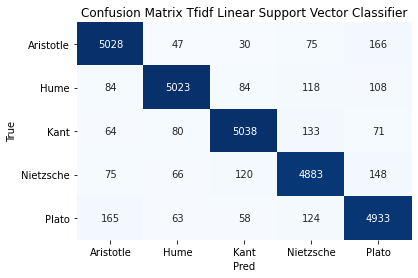

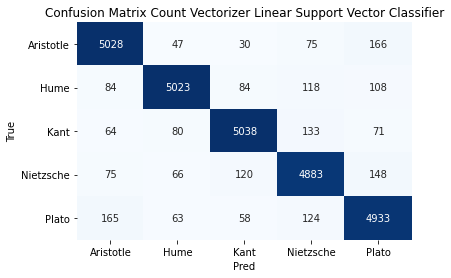

In [ ]:
## Plot confusion matrix

classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix Tfidf Linear Support Vector Classifier")
plt.yticks(rotation=0)
plt.show()


classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix Count Vectorizer Linear Support Vector Classifier")
plt.yticks(rotation=0)
plt.show()



### SVC: Classification Report 

In [ ]:
print(f"Tfidf Support Vector Classifier Accuracy: {accuracy_score(predictions,y_test)}")

print(f"Tfidf Support Vector Classifier Kappa Score: {cohen_kappa_score(predictions,y_test)}")

print("\t")
print("\t")

print(f"Count Vectorizer Support Vector Classifier Accuracy: {accuracy_score(predicitions_two,y_test)}")

print(f"Count Vectorizer Support Vector Classifier Kappa Score: {cohen_kappa_score(predicitions_two,y_test)}")

Tfidf Support Vector Classifier Accuracy: 0.9298461768219832
Tfidf Support Vector Classifier Kappa Score: 0.9123085641947849
	
	
Count Vectorizer Support Vector Classifier Accuracy: 0.9163679808841099
Count Vectorizer Support Vector Classifier Kappa Score: 0.8954607406416364


In [ ]:
print("Tfidf Vectorizer Support Vector Classification Report")
print("\t")
print(classification_report(predictions,y_test))
print("\t")
print("\t")
print("Count Vectorizer Support Vector Classification Report")
print("\t")
print(classification_report(predicitions_two,y_test))

Tfidf Vectorizer Support Vector Classification Report
	
              precision    recall  f1-score   support

         ALE       0.94      0.93      0.93      5416
         HUM       0.93      0.95      0.94      5279
         KNT       0.94      0.95      0.94      5330
         NZE       0.92      0.92      0.92      5333
         PLT       0.92      0.91      0.92      5426

    accuracy                           0.93     26784
   macro avg       0.93      0.93      0.93     26784
weighted avg       0.93      0.93      0.93     26784

	
	
Count Vectorizer Support Vector Classification Report
	
              precision    recall  f1-score   support

         ALE       0.93      0.92      0.93      5422
         HUM       0.90      0.95      0.92      5162
         KNT       0.93      0.93      0.93      5379
         NZE       0.90      0.92      0.91      5179
         PLT       0.91      0.86      0.89      5642

    accuracy                           0.92     26784
   macro avg   

# SUPPORT VECTOR CLASSIFIER: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Support Vector Classifier: GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Tuning hyper parameters forr Linear svc classifier 

'''penalty : str, 'l1' or 'l2' (default='l2')
    Specifies the norm used in the penalization. The 'l2'
    penalty is the standard used in SVC. The 'l1' leads to ``coef_``
    vectors that are sparse.

loss : str, 'hinge' or 'squared_hinge' (default='squared_hinge')
    Specifies the loss function. 'hinge' is the standard SVM loss
    (used e.g. by the SVC class) while 'squared_hinge' is the
    square of the hinge loss.


tol : float, optional (default=1e-4)
    Tolerance for stopping criteria.

C : float, optional (default=1.0)
    Regularization parameter. The strength of the regularization is
    inversely proportional to C. Must be strictly positive.

multi_class : str, 'ovr' or 'crammer_singer' (default='ovr')
    Determines the multi-class strategy if `y` contains more than
    two classes.
    ``"ovr"`` trains n_classes one-vs-rest classifiers, while
    ``"crammer_singer"`` optimizes a joint objective over all classes.
    While `crammer_singer` is interesting from a theoretical perspective
    as it is consistent, it is seldom used in practice as it rarely leads
    to better accuracy and is more expensive to compute.
    If ``"crammer_singer"`` is chosen, the options loss, penalty and dual
    will be ignored.

fit_intercept : bool, optional (default=True)
    Whether to calculate the intercept for this model. If set
    to false, no intercept will be used in calculations
    (i.e. data is expected to be already centered).

intercept_scaling : float, optional (default=1)
    When self.fit_intercept is True, instance vector x becomes
    ``[x, self.intercept_scaling]``,
    i.e. a "synthetic" feature with constant value equals to
    intercept_scaling is appended to the instance vector.
    The intercept becomes intercept_scaling * synthetic feature weight
    Note! the synthetic feature weight is subject to l1/l2 regularization
    as all other features.
    To lessen the effect of regularization on synthetic feature weight
    (and therefore on the intercept) intercept_scaling has to be increased.

class_weight : {dict, 'balanced'}, optional
    Set the parameter C of class i to ``class_weight[i]*C`` for
    SVC. If not given, all classes are supposed to have
    weight one.
    The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``.

verbose : int, (default=0)
    Enable verbose output. Note that this setting takes advantage of a
    per-process runtime setting in liblinear that, if enabled, may not work
    properly in a multithreaded context.

random_state : int, RandomState instance or None, optional (default=None)
    The seed of the pseudo random number generator to use when shuffling
    the data for the dual coordinate descent (if ``dual=True``). When
    ``dual=False`` the underlying implementation of :class:`LinearSVC`
    is not random and ``random_state`` has no effect on the results. If
    int, random_state is the seed used by the random number generator; If
    RandomState instance, random_state is the random number generator; If
    None, the random number generator is the RandomState instance used by
    `np.random`.

max_iter : int, (default=1000)
    The maximum number of iterations to be run.

Attributes
----------
coef_ : array, shape = [1, n_features] if n_classes == 2 else [n_classes, n_features]
    Weights assigned to the features (coefficients in the primal
    problem). This is only available in the case of a linear kernel.

    ``coef_`` is a readonly property derived from ``raw_coef_`` that
    follows the internal memory layout of liblinear.

intercept_ : array, shape = [1] if n_classes == 2 else [n_classes]
    Constants in decision function.

classes_ : array of shape (n_classes,)
    The unique classes labels.

n_iter_ : int
    Maximum number of iterations run across all classes. '''


'penalty : str, \'l1\' or \'l2\' (default=\'l2\')\n    Specifies the norm used in the penalization. The \'l2\'\n    penalty is the standard used in SVC. The \'l1\' leads to ``coef_``\n    vectors that are sparse.\n\nloss : str, \'hinge\' or \'squared_hinge\' (default=\'squared_hinge\')\n    Specifies the loss function. \'hinge\' is the standard SVM loss\n    (used e.g. by the SVC class) while \'squared_hinge\' is the\n    square of the hinge loss.\n\n\ntol : float, optional (default=1e-4)\n    Tolerance for stopping criteria.\n\nC : float, optional (default=1.0)\n    Regularization parameter. The strength of the regularization is\n    inversely proportional to C. Must be strictly positive.\n\nmulti_class : str, \'ovr\' or \'crammer_singer\' (default=\'ovr\')\n    Determines the multi-class strategy if `y` contains more than\n    two classes.\n    ``"ovr"`` trains n_classes one-vs-rest classifiers, while\n    ``"crammer_singer"`` optimizes a joint objective over all classes.\n    While 

## Naive Bayes Multinomial Classifer NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Pipeline 1- tdif:
nb_clf = Pipeline([('tdif',TfidfVectorizer()),
                   ('naivebaiyes',MultinomialNB(alpha=0.1,
                    class_prior=None ,fit_prior=True))])

# Pipeline 2- Count Vect:
count_nb_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),
                   ('naivebaiyes',MultinomialNB(alpha=0.1,
                    class_prior=None ,fit_prior=True))])

In [ ]:
%%time 
# Fit Tfidf Model
nb_clf.fit(X_train,y_train)

# Fit Count Vectorizer Model
count_nb_clf.fit(X_train,y_train)

CPU times: user 3.92 s, sys: 13.8 ms, total: 3.94 s
Wall time: 3.92 s


In [ ]:
# Using Tfidf to predict test set
pred = nb_clf.predict(X_test)

# Using Count Vectorizer to predict test set
pred_2 = count_nb_clf.predict(X_test)

### Multinomial NB Model Performance

In [ ]:


print(f"Tfidf Multinomial NB Classifier Accuracy: {accuracy_score(pred,y_test)}")
print(f"Tfidf Multinomial NB Classifier Kappa Score: {cohen_kappa_score(pred,y_test)}")
print("\t")
print("\t")
print(f"Count Vectorizer Multinomial NB Classifier Accuracy: {accuracy_score(pred_2,y_test)}")
print(f"Count Vectorizer Multinomial NB Classifer Kappa Score: {cohen_kappa_score(pred_2,y_test)}")

Tfidf Multinomial NB Classifier Accuracy: 0.8895982676224612
Tfidf Multinomial NB Classifier Kappa Score: 0.8619946241037704
	
	
Count Vectorizer Multinomial NB Classifier Accuracy: 0.8733198924731183
Count Vectorizer Multinomial NB Classifer Kappa Score: 0.8416481833661803


### MultinomialNB: Confusion Matrix

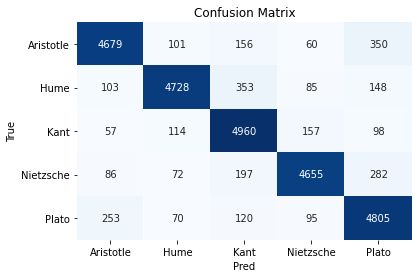

In [ ]:
# MultinomialNB Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

### MultinomialNB: Classification Report 

In [ ]:
print("Tfidf Multinomial NB Classification Report")
print("\t")
print(classification_report(pred,y_test))
print("\t")
print("\t")
print("Count Vectorizer Multinomial NB Classification Report")
print("\t")
print(classification_report(pred_2,y_test))

Tfidf Multinomial NB Classification Report
	
              precision    recall  f1-score   support

         ALE       0.88      0.90      0.89      5178
         HUM       0.87      0.93      0.90      5085
         KNT       0.92      0.86      0.89      5786
         NZE       0.88      0.92      0.90      5052
         PLT       0.90      0.85      0.87      5683

    accuracy                           0.89     26784
   macro avg       0.89      0.89      0.89     26784
weighted avg       0.89      0.89      0.89     26784

	
	
Count Vectorizer Multinomial NB Classification Report
	
              precision    recall  f1-score   support

         ALE       0.86      0.89      0.88      5162
         HUM       0.87      0.91      0.89      5179
         KNT       0.90      0.85      0.87      5682
         NZE       0.87      0.88      0.88      5242
         PLT       0.86      0.83      0.85      5519

    accuracy                           0.87     26784
   macro avg       0.87   

# NAIVE BAYES: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Naives Bayes: GridSearchCV

In [ ]:
param_grid = {'alpha': [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid = GridSearchCV(MultinomialNB(),param_grid,refit=True,verbose=2,cv=5)

tfid = TfidfVectorizer()
tfid_X_train = tfid.fit_transform(X_train)

tfid_X_test = tfid.fit_transform(X_test)

grid.fit(tfid_X_train,y_train)

print("Best Estimator: ",grid.best_estimator_)
print("Best Score: ", grid.best_score_)

## XGBoost & RandomForest Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# xgb_clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

tdif_xgb_clf = Pipeline([('tdif',TfidfVectorizer()),
                   ('XGBoost',XGBClassifier())]) #random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7

count_vect_xgb_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),
                   ('XGBoost',XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7))])

rf_clf = Pipeline([('tdif',TfidfVectorizer()),('rf',RandomForestClassifier())])


In [ ]:
%%time

# training tfidf xgboost model
tdif_xgb_clf.fit(X_train,y_train)
# training count vectorizer xgboost model
count_vect_xgb_clf.fit(X_train,y_train)
# training tfidf Randomforest model
rf_clf.fit(X_train,y_train)


CPU times: user 6min 46s, sys: 753 ms, total: 6min 47s
Wall time: 6min 45s


In [ ]:
# Predicting Values for both models
predictions = tdif_xgb_clf.predict(X_test)

predictions_two = count_vect_xgb_clf.predict(X_test)

predictions_rf = rf_clf.predict(X_test)


### XGBoost Classifier Model Performance

In [ ]:
# Model and Kappa Score

print(f"Tfidf XGBoost Classifier Accuracy: {accuracy_score(predictions,y_test)}")
print(f"Tfidf XGBoost Classifier Kappa Score: {cohen_kappa_score(predictions,y_test)}")
print("\t")
print("\t")
print(f"Count Vectorizer XGBoost Classifier Accuracy: {accuracy_score(predictions_two,y_test)}")
print(f"Count Vectorizer XGBoost Classifer Kappa Score: {cohen_kappa_score(predictions_two,y_test)}")
print("\t")
print("\t")
print(f"Tfidf Vectorizer RandomForest Classifier Accuracy: {accuracy_score(predictions_rf,y_test)}")
print(f"Tfidf Vectorizer RandomForest Classifier Kappa Score: {cohen_kappa_score(predictions_rf,y_test)}")


Tfidf XGBoost Classifier Accuracy: 0.6674880525686977
Tfidf XGBoost Classifier Kappa Score: 0.584421966698123
	
	
Count Vectorizer XGBoost Classifier Accuracy: 0.6115218040621266
Count Vectorizer XGBoost Classifer Kappa Score: 0.5146914272355401
	
	
Tfidf Vectorizer RandomForest Classifier Accuracy: 0.90165770609319
Tfidf Vectorizer RandomForest Classifier Kappa Score: 0.8770728452822206


### XGBoost & RandomForest: Confusion Matrix

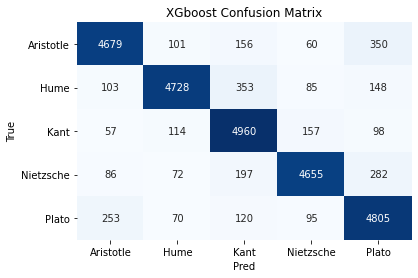

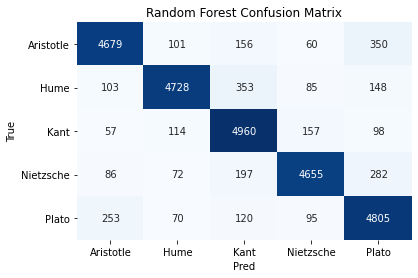

In [ ]:
confusion_matrix(predictions,y_test)

# XGboost Classifier Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="XGboost Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


confusion_matrix(predictions_rf,y_test)

# Random Forest Classifier Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Random Forest Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

### XGBoost & RandomForest: Classificaion Report

In [ ]:

print("Tfidf XGBoost Classification Report")
print(classification_report(predictions,y_test))
print("\t")
print("Countvector XGBoost Classification Report")
print(classification_report(predictions_two,y_test))
print("\t")
print("Tfidf Random Forest Classifier Classification Report")
print(classification_report(predictions_rf,y_test))



Tfidf XGBoost Classification Report
              precision    recall  f1-score   support

         ALE       0.66      0.62      0.64      5687
         HUM       0.66      0.71      0.68      4999
         KNT       0.69      0.78      0.73      4773
         NZE       0.64      0.56      0.60      6041
         PLT       0.69      0.70      0.70      5284

    accuracy                           0.67     26784
   macro avg       0.67      0.67      0.67     26784
weighted avg       0.67      0.67      0.67     26784

	
Countvector XGBoost Classification Report
              precision    recall  f1-score   support

         ALE       0.51      0.65      0.57      4169
         HUM       0.57      0.82      0.67      3752
         KNT       0.68      0.77      0.73      4756
         NZE       0.73      0.42      0.54      9157
         PLT       0.57      0.61      0.59      4950

    accuracy                           0.61     26784
   macro avg       0.61      0.66      0.62     267

# XGBOOST & RANDOMFOREST CLASSIFIER: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## XGBoost Classifier: GridSearchCV

# MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Hyperparameter Tuning GRIDCV 

In [ ]:


# grid = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2,cv=5)



# grid.fit(tfid_X_train,y_train)


In [ ]:
# print(grid.best_estimator_)

# DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving models

In [236]:

from sklearn.externals import joblib
sv = 'svc_clf.sav' 
mb = 'multinb_clf.sav'
xgb = 'xbg_clf.csv'
rf = 'rf_clf.csv'

joblib.dump('svc_clf',sv)
joblib.dump('multinb_clf',mb)
joblib.dump('xgb_clf',xgb)
joblib.dump('rf_clf',rf)

['rf_clf.csv']

# NEURAL NETWORK MODELLING PHASE - PHILOSOPHERS TEXT 

## Deep Learning with **Keras**


## NEURAL NETWORK MODEL DATA PRE-PROCESSING

In [239]:

# Importing Layers, Sequential Model, Feature Extraction, Text Pre-processing, Tokenizer
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import utils 


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping



In [240]:
 
 # Split between variables into input and target variable
 X = df_stratified.sentence

 y = df_stratified.label
 

In [241]:
from tensorflow import keras

labels = keras.utils.to_categorical(y,num_classes=5)


In [242]:
from keras.preprocessing.text import Tokenizer
from keras import utils 

n_most_common_words = 40000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values) 
sequences = tokenizer.texts_to_sequences(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 37426 unique tokens.


In [ ]:
word_index

## LSTM ARCHITECTURE & TRAINING

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)


In [246]:
epochs = 15
emb_dim = 128
batch_size = 256
vocab = len(word_index) + 1

In [247]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# Model layers
lstm_model = Sequential()
lstm_model.add(Embedding(vocab, emb_dim, input_length=X.shape[1]))
# model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
lstm_model.add(SpatialDropout1D(0.7)) ## different dropout options = 0.2, 0.8, 0.7
lstm_model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
lstm_model.add(Dense(5, activation='softmax'))

# Model Compiler
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Model Summary
print(lstm_model.summary())


((80350, 130), (80350, 5), (26784, 130), (26784, 5))
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 130, 128)          4790656   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 325       
Total params: 4,840,389
Trainable params: 4,840,389
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

%%time 
history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=256,validation_split=0.2
                    ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)],shuffle=True) #batch_size 37, 256, 300


Epoch 1/15
252/252 [==============================] - 101s 393ms/step - loss: 1.2316 - acc: 0.4847 - val_loss: 0.7100 - val_acc: 0.7346
Epoch 2/15
252/252 [==============================] - 98s 390ms/step - loss: 0.7125 - acc: 0.7437 - val_loss: 0.4605 - val_acc: 0.8448
Epoch 3/15
252/252 [==============================] - 98s 389ms/step - loss: 0.5355 - acc: 0.8119 - val_loss: 0.3798 - val_acc: 0.8716
Epoch 4/15
252/252 [==============================] - 98s 390ms/step - loss: 0.4470 - acc: 0.8440 - val_loss: 0.3268 - val_acc: 0.8892
Epoch 5/15
252/252 [==============================] - 98s 389ms/step - loss: 0.3854 - acc: 0.8657 - val_loss: 0.3118 - val_acc: 0.8953
Epoch 6/15
252/252 [==============================] - 98s 390ms/step - loss: 0.3408 - acc: 0.8815 - val_loss: 0.2944 - val_acc: 0.8997
Epoch 7/15
252/252 [==============================] - 99s 391ms/step - loss: 0.3024 - acc: 0.8965 - val_loss: 0.2740 - val_acc: 0.9110
Epoch 8/15
252/252 [==============================] - 

# LSTM: EVALUATION PHASE - PHILOSOPHERS TEXT

## LSTM Model Evaluation





### LSTM model accuracy

In [ ]:

# Determining Accuracy of the LSTM model
accr = lstm_model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]))


837/837 [==============================] - 27s 33ms/step - loss: 0.2515 - acc: 0.9271
Test set
  Loss: 0.25
  Accuracy: 0.93


### LSTM: Predictions and Model Metrics

In [ ]:

# Using LSTM to generate predictions on the test set
predictions = lstm_model.predict(x= X_test, batch_size = 10, verbose = 1) 


2679/2679 [==============================] - 82s 31ms/step


In [ ]:

# Rounding the predictions to generate the labels 
rounded_predictions = np.argmax(predictions,axis=-1)

# Making sure predictions are transformed into labels
rounded_predictions 

array([2, 1, 4, ..., 4, 2, 0])

### LSTM: Classification Report 

In [ ]:

# Importing metric libraries 
from sklearn.metrics import confusion_matrix,classification_report

# Turning the rounded predictions into a dataframe 
labels_pred = pd.DataFrame(rounded_predictions)
labels_pred.shape
y_test_sorted = np.argmax(y_test,axis=-1)

# Generate Confusion Matrix 
cm = confusion_matrix(y_true=y_test_sorted,y_pred=rounded_predictions)

# Generate and Print Classification Report 
classifcation_rep = (classification_report(y_test_sorted,rounded_predictions))
print("\n")
print(classifcation_rep)




              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5386
           1       0.96      0.92      0.94      5417
           2       0.88      0.94      0.91      5343
           3       0.94      0.93      0.93      5346
           4       0.91      0.92      0.91      5292

    accuracy                           0.93     26784
   macro avg       0.93      0.93      0.93     26784
weighted avg       0.93      0.93      0.93     26784



### LSTM Confusion Matrix

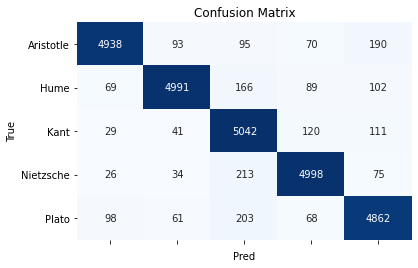

In [ ]:

# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### LSTM: Plotting Result to Compare training vs. Validation 

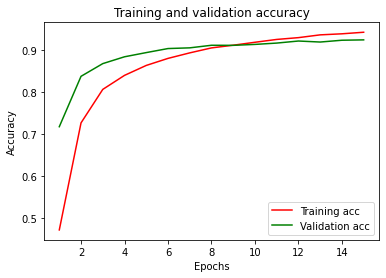

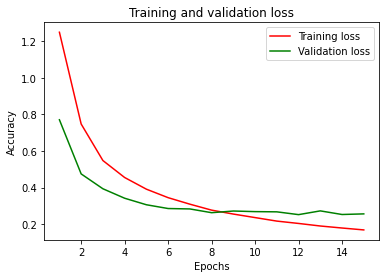

In [ ]:

# Comparing training and validation accuracy 

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### LSTM: Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(y_test_sorted,rounded_predictions))

0.908856987829618


### LSTM: Hyperparameter Tuning GRIDCV 

In [ ]:

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import rmsprop_v2

def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=130)) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(5, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [ ]:
import numpy as np
seed = 7
np.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
628/628 [==============================] - 2s 2ms/step - loss: 1.5246 - accuracy: 0.4218
Epoch 2/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4677 - accuracy: 0.4223
Epoch 3/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4632 - accuracy: 0.4223
Epoch 4/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4630 - accuracy: 0.4223
Epoch 5/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 6/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 7/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 8/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 9/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 10/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223

# DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving LSTM model

In [ ]:
# lstm_model.save("lstm_model.h5")
# load.model('/content/lstm_model.h5')

## **BI-LSTM MODEL**


In [212]:

# Importing keras from tensorflow 
from tensorflow import keras
# from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
# Importing utilities from keras
from keras import utils
# Importing tokenizers, sequences and padding for text wrangling
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
# Importing Sequences, early stopping to instantiate and moderate overfitting
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# Imlaypers required for Neural network model architecture
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D


## BI-LSTM DATA PRE-PROCESSING

In [ ]:

# Creating input and output variables
sentences = df_n.sentence
labels = df_n.label


In [ ]:

# Importing and fitting tokenizer
from keras.preprocessing.text import Tokenizer
max_words = 40000
max_len = 130
tokenize = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenize.fit_on_texts(sentences.values)
# Converting texts to sequences then into a word index
sequences = tokenize.texts_to_sequences(sentences.values)
word_index = tokenize.word_index
print(len(word_index))
# Pading texts to limit the word count
X = pad_sequences(sequences,maxlen=max_len)
y = keras.utils.to_categorical(labels.values,num_classes=5)



45761


In [ ]:

# splitting training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=42)


In [ ]:

# Defining the number of epochs, embedding dimensions, batch size and vocab length required in the model
epochs = 15
emb_dim = 130
batch_size = 256
vocab = len(word_index) + 1


In [ ]:

# Checking that training and test set are the same input dims
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((85707, 130), (85707, 5), (21427, 130), (21427, 5))


## BI-LSTM MODEL ARCHITECTURE & TRAINING

### BI-LSTM MODEL ARCHITECTURE 1

In [ ]:

# Model Architecture 1

bi_lstm_model1= Sequential()

bi_lstm_model1.add(Embedding(vocab,emb_dim))
# model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
bi_lstm_model1.add(Dropout(0.5)) # (0.5 ,0.8) was the previous more hardline dropout 
bi_lstm_model1.add(Bidirectional(LSTM(emb_dim)))#emb_dim
bi_lstm_model1.add(Dense(5,activation='softmax'))

bi_lstm_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bi_lstm_model1.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 130)         4865510   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 130)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 260)               271440    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1305      
Total params: 5,138,255
Trainable params: 5,138,255
Non-trainable params: 0
_________________________________________________________________


### BI-LSTM MODEL ARCHITECTURE 2

In [216]:

# Model Architecture 2

model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(vocab,emb_dim))
# model_bi_lstm.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
model_bi_lstm.add(SpatialDropout1D(0.3))
model_bi_lstm.add(Bidirectional(LSTM(emb_dim, dropout=0.3, recurrent_dropout=0.3)))
model_bi_lstm.add(Dense(emb_dim, activation='relu'))
model_bi_lstm.add(Dropout(0.8))
model_bi_lstm.add(Dense(emb_dim, activation='relu')) # relu, tanh sigmoid
model_bi_lstm.add(Dropout(0.8))
model_bi_lstm.add(Dense(5,activation='softmax'))
model_bi_lstm.summary()
model_bi_lstm.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) # adam > RMSprop


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, None, 130)         4865510   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 130)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260)               271440    
_________________________________________________________________
dense_48 (Dense)             (None, 130)               33930     
_________________________________________________________________
dropout_42 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 130)               17030     
_________________________________________________________________
dropout_43 (Dropout)         (None, 130)             

In [217]:
%%time
epoch = 15

history = model_bi_lstm.fit(X_train, y_train, epochs=epoch, batch_size=128,validation_split=0.2
                    ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Epoch 1/15
536/536 [==============================] - 403s 744ms/step - loss: 1.2022 - accuracy: 0.4791 - val_loss: 0.6173 - val_accuracy: 0.7970
Epoch 2/15
536/536 [==============================] - 398s 743ms/step - loss: 0.5703 - accuracy: 0.8235 - val_loss: 0.3604 - val_accuracy: 0.8839
Epoch 3/15
536/536 [==============================] - 399s 745ms/step - loss: 0.3746 - accuracy: 0.8934 - val_loss: 0.3121 - val_accuracy: 0.9042
Epoch 4/15
536/536 [==============================] - 398s 742ms/step - loss: 0.2785 - accuracy: 0.9236 - val_loss: 0.3247 - val_accuracy: 0.9088
Epoch 5/15
536/536 [==============================] - 400s 745ms/step - loss: 0.2352 - accuracy: 0.9346 - val_loss: 0.3217 - val_accuracy: 0.9168
Epoch 6/15
536/536 [==============================] - 398s 742ms/step - loss: 0.2008 - accuracy: 0.9458 - val_loss: 0.3239 - val_accuracy: 0.9172
Epoch 7/15
536/536 [==============================] - 398s 742ms/step - loss: 0.1738 - accuracy: 0.9532 - val_loss: 0.3470 -

# BI-LSTM EVALUATION PHASE - PHILOSOPHERS TEXT

## Bi-LSTM Model Evaluation 





### Bi-LSTM: Model Accuracy

In [219]:

# Determining Accuracy of the Bi-LSTM model
accr = model_bi_lstm.evaluate(X_test,y_test)
# accr_1 = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


670/670 [==============================] - 37s 55ms/step - loss: 0.3813 - accuracy: 0.9257
Test set
  Loss: 0.381
  Accuracy: 0.926


### Bi-LSTM: Predictions On Test Set

In [220]:

# Bi-LSTM model predictions on test set 

predictions = model_bi_lstm.predict(x= X_test, batch_size = 10, verbose = 2)


2143/2143 - 110s


In [221]:

# Derive rounded predictions that will shift probability of class into actual prediction

rounded_predictions = np.argmax(predictions,axis=-1)


# Test to verify prediciton outputt after rounding

rounded_predictions

y_test_sorted = np.argmax(y_test,axis=-1)
y_test_sorted
rounded_predictions

array([2, 1, 4, ..., 0, 0, 3])

### BI-LSTM: Classification Report 


In [222]:
from sklearn.metrics import classification_report

# Generate and Print Classification Report 
classifcation_rep = (classification_report(y_test_sorted,rounded_predictions))
print("\n")
print(classifcation_rep)





              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4331
           1       0.94      0.93      0.93      4321
           2       0.91      0.93      0.92      4294
           3       0.92      0.93      0.93      4261
           4       0.93      0.89      0.91      4220

    accuracy                           0.93     21427
   macro avg       0.93      0.93      0.93     21427
weighted avg       0.93      0.93      0.93     21427



### BI-LSTM: Confusion Matrix

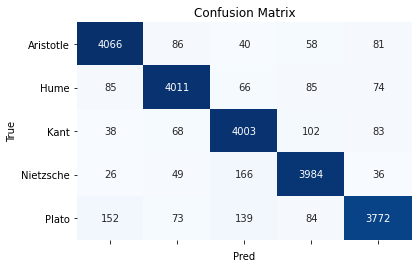

In [223]:

# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### BI-LSTM: Kappa Statistic

In [226]:

from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test_sorted,rounded_predictions))



0.907179839500185


### BI-LSTM: Plotting Result to Compare Model Performance on Training & Validation Set

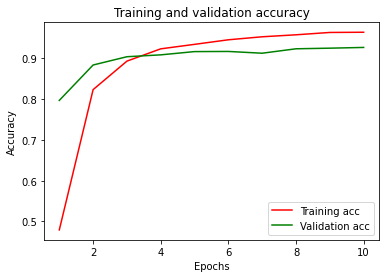

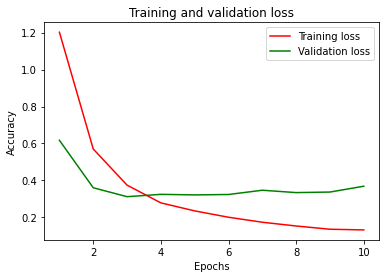

In [227]:

# Verifying accuracy of training set versus validation set

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### BI-LSTM: Hyperparameter Tuning GRIDCV 

In [ ]:

optimize = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']

activators = ['relu','sigmoid','softmax','softplus','softsign','tanh','selu','elu','exponential']

batch_sizes = [47,128,256,500]

epoch_tests = [10,15,20,40]


# BI-LSTM: DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving Bi-LSTM model

In [ ]:
# bi_lstm_model1.save("bi-lstm_modelstrat.h5")
# load.model('/content/bi-lstm_model2.h5')

In [ ]:
# Importing the developed Bi-LSTM models

# from tensorflow import keras

# model = keras.models.load_model('/content/bi-lstm_model22.h5')

# GRU MODEL

In [167]:

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,Flatten,MaxPooling1D,GRU
from keras.callbacks import EarlyStopping


## GRU MODEL ARCHITECTURE & TRAINING

In [203]:

gru_model = Sequential()
gru_model.add(Embedding(vocab,emb_dim))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.8))
gru_model.add(Dense(5, activation = 'sigmoid'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())



Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, None, 130)         4865510   
_________________________________________________________________
gru_20 (GRU)                 (None, 128)               99840     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 645       
Total params: 4,965,995
Trainable params: 4,965,995
Non-trainable params: 0
_________________________________________________________________
None


In [204]:

%%time
history = gru_model.fit(X_train, y_train,validation_split=0.2,
                        epochs=15, batch_size= 128 ,verbose=2,shuffle=True) # 256


Epoch 1/15
536/536 - 8s - loss: 0.7217 - accuracy: 0.7264 - val_loss: 0.3324 - val_accuracy: 0.8874
Epoch 2/15
536/536 - 6s - loss: 0.2456 - accuracy: 0.9236 - val_loss: 0.2738 - val_accuracy: 0.9103
Epoch 3/15
536/536 - 6s - loss: 0.1588 - accuracy: 0.9518 - val_loss: 0.2568 - val_accuracy: 0.9214
Epoch 4/15
536/536 - 6s - loss: 0.1134 - accuracy: 0.9657 - val_loss: 0.2838 - val_accuracy: 0.9246
Epoch 5/15
536/536 - 6s - loss: 0.0904 - accuracy: 0.9727 - val_loss: 0.3080 - val_accuracy: 0.9219
Epoch 6/15
536/536 - 6s - loss: 0.0754 - accuracy: 0.9772 - val_loss: 0.2919 - val_accuracy: 0.9301
Epoch 7/15
536/536 - 6s - loss: 0.0607 - accuracy: 0.9821 - val_loss: 0.3242 - val_accuracy: 0.9295
Epoch 8/15
536/536 - 6s - loss: 0.0566 - accuracy: 0.9830 - val_loss: 0.3629 - val_accuracy: 0.9197
Epoch 9/15
536/536 - 6s - loss: 0.0406 - accuracy: 0.9879 - val_loss: 0.3841 - val_accuracy: 0.9258
Epoch 10/15
536/536 - 6s - loss: 0.0407 - accuracy: 0.9882 - val_loss: 0.3757 - val_accuracy: 0.9259

# GRU: EVALUATION PHASE - PHILOSOPHERS TEXT

## GRU Model Evaluation 


## GRU: Accuracy

In [205]:

# Determining Accuracy of the GRU model
accr = gru_model.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


670/670 [==============================] - 3s 4ms/step - loss: 0.5018 - accuracy: 0.9277
Test set
  Loss: 0.502
  Accuracy: 0.928


In [206]:
predictions = gru_model.predict(X_test)

predictions = np.argmax(predictions,axis=-1)

predictions


y_test_sorted = np.argmax(y_test,axis=-1)

y_test_sorted

array([2, 1, 4, ..., 0, 0, 3])

### GRU: Confusion Matrix

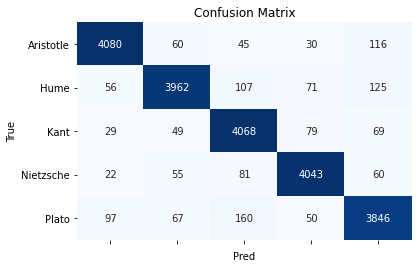

In [207]:
cm = confusion_matrix(predictions,y_test_sorted)


# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### GRU: Classification Report

In [208]:
print(classification_report(predictions,y_test_sorted))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4487
           1       0.92      0.94      0.93      4211
           2       0.91      0.94      0.93      4163
           3       0.95      0.93      0.94      4326
           4       0.91      0.91      0.91      4240

    accuracy                           0.93     21427
   macro avg       0.93      0.93      0.93     21427
weighted avg       0.93      0.93      0.93     21427



### Kappa Statistic

In [209]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(predictions,y_test_sorted))


0.9096332019753358


### GRU: Plotting Result to Compare Model Performance on Training & Validation Set

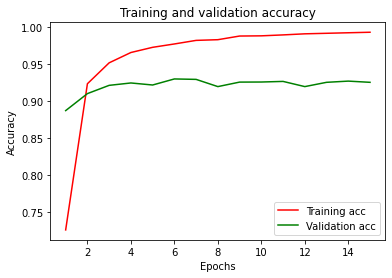

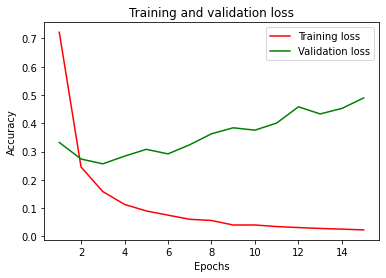

In [210]:

# Verifying accuracy of training set versus validation set

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN MODEL


In [76]:
from tensorflow import keras 
from keras.preprocessing import sequence,text
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,SpatialDropout1D
from keras.callbacks import EarlyStopping


In [ ]:

# Initialising input variables 

sentences = df_n['sentence']

labels = df_n['label']


In [ ]:

max_words = 40000
max_len = 130
tokenize = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenize.fit_on_texts(sentences.values)
# Converting texts to sequences then into a word index
sequences = tokenize.texts_to_sequences(sentences.values)
word_index = tokenize.word_index
print(len(word_index))
# Pading texts to limit the word count
X = pad_sequences(sequences,maxlen=max_len)
y = keras.utils.to_categorical(labels.values,num_classes=5)


45761


In [ ]:

# splitting training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=42)


In [81]:
# Defining the number of epochs, embedding dimensions, batch size and vocab length required in the model
epochs = 50
emb_dim = 130
batch_size = 256
vocab = len(word_index) + 1


In [ ]:
# Checking that training and test set are the same input dims
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((80350, 130), (80350, 5), (26784, 130), (26784, 5))


## CNN MODEL ARCHITECTURE & TRAINING

In [82]:
model_cnn = Sequential()
model_cnn.add((Embedding(vocab,emb_dim)))
# model_cnn.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))

model_cnn.add(Dense(5,activation='softmax'))


model_cnn.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy']) # RMSprop

model_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 130)         4865510   
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 130)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          25024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)               

In [110]:
%%time
history = model_cnn.fit(X_train, y_train,validation_split=0.2,epochs=15, batch_size=128,verbose=2,shuffle=True)



Epoch 1/15
536/536 - 3s - loss: 0.0029 - accuracy: 0.9992 - val_loss: 1.0388 - val_accuracy: 0.9271
Epoch 2/15
536/536 - 3s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.9980 - val_accuracy: 0.9253
Epoch 3/15
536/536 - 3s - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.9794 - val_accuracy: 0.9278
Epoch 4/15
536/536 - 3s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 1.0245 - val_accuracy: 0.9289
Epoch 5/15
536/536 - 3s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 1.0572 - val_accuracy: 0.9288
Epoch 6/15
536/536 - 3s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 1.0415 - val_accuracy: 0.9280
Epoch 7/15
536/536 - 3s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 1.0524 - val_accuracy: 0.9281
Epoch 8/15
536/536 - 3s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 1.0571 - val_accuracy: 0.9291
Epoch 9/15
536/536 - 3s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 1.1363 - val_accuracy: 0.9232
Epoch 10/15
536/536 - 3s - loss: 0.0018 - accuracy: 0.9994 - val_loss: 1.1927 - val_accuracy: 0.9282

# CNN: EVALUATION PHASE - PHILOSOPHERS TEXT

## CNN Model Evaluation 


### CNN: Accuracy

In [84]:

accr = model_cnn.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


670/670 [==============================] - 1s 2ms/step - loss: 0.4431 - accuracy: 0.9334
Test set
  Loss: 0.443
  Accuracy: 0.933


### CNN: Predictions On Test Set

In [85]:

# Bi-LSTM model predictions on test set 

predictions = model_cnn.predict(x= X_test, batch_size = 10, verbose = 2)


2143/2143 - 2s


In [86]:
# Derive rounded predictions that will shift probability of class into actual prediction

rounded_predictions = np.argmax(predictions,axis=-1)

# Test to verify prediciton outputt after rounding

rounded_predictions

array([2, 1, 4, ..., 0, 0, 3])

## CNN: Classification Report

In [102]:

from sklearn.metrics import confusion_matrix, classification_report
# Turning the rounded predictions into a dataframe 
labels_pred = pd.DataFrame(rounded_predictions)
labels_pred.shape
y_test_sorted = np.argmax(y_test,axis=-1)
                          
print(classification_report(y_test_sorted,rounded_predictions))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4331
           1       0.94      0.92      0.93      4321
           2       0.91      0.95      0.93      4294
           3       0.95      0.95      0.95      4261
           4       0.91      0.91      0.91      4220

    accuracy                           0.93     21427
   macro avg       0.93      0.93      0.93     21427
weighted avg       0.93      0.93      0.93     21427



### CNN: Confusion Matrix

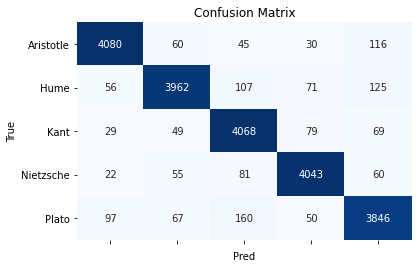

In [88]:


# Generate Confusion Matrix 
cm = confusion_matrix(y_true=y_test_sorted,y_pred=rounded_predictions)


# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

### CNN: Kappa Score

In [89]:
from sklearn.metrics import cohen_kappa_score


print(cohen_kappa_score(y_test_sorted,rounded_predictions))

0.9166932108550228


### CNN: Plotting Training & Validation Accuracy and Loss

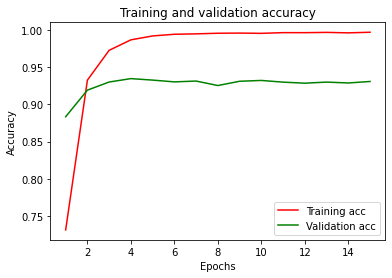

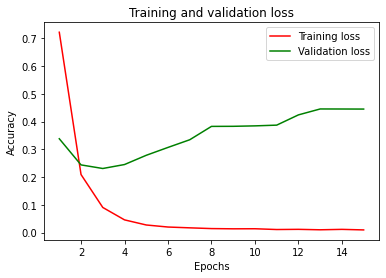

In [103]:

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN: DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving CNN model

In [91]:
# model.save('CNN_noembed.h5')

# Word Embedding

## Glove Embeddings

In [60]:
sentences = df_stratified.sentence

labels = df_stratified.label

# Set max words for entire vocab and max len for padded sequences 
max_words = 40000
max_len = 130

# Text pre-processing libraries 

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# y to categorical

y = keras.utils.to_categorical(labels)

# Instantiate tokenizer 
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# # create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(sentences)
# # generate the sequence of tokens
sent_seq = tokenizer.texts_to_sequences(sentences)
# xtest_seq = tokenizer.texts_to_sequences(X_test)

# # pad the sequences
sent_pad = sequence.pad_sequences(sent_seq, maxlen=max_len)
# xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index


# Split data into training and test set. 
X_train, X_test, y_train, y_test = train_test_split(sent_pad, y, test_size=0.20, random_state=42)



In [61]:

# Print an example of a training sentence 
print('text example:', sentences[1])
# Print an example of a the training sentence as a sequence
print('text sequence:', sent_seq[1])
# Print an example of a padded sequence 
print('text padded:', sent_pad[1])


text example: 1    that goes merely into our faculty of knowing t...
1    that goes merely into our faculty of knowing t...
1    that goes merely into our faculty of knowing t...
Name: sentence, dtype: object
text sequence: [1, 4198, 2, 1, 185, 344, 5, 59]
text padded: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1 4198    2    1
  185  344    5   59]


In [62]:
%%time 
import numpy as np
embedding_vec = {}

with open('/content/drive/MyDrive/data/glove.6B.100d.txt','r',encoding='utf-8') as file:
  for row in file:
    values = row.split(" ")
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vec[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vec)}")  

Size of vocabulary in GloVe: 400000
CPU times: user 11.2 s, sys: 304 ms, total: 11.5 s
Wall time: 11.4 s


In [31]:
embedding_vec['fuck'], embedding_vec['you']

(array([ 0.098204 , -0.31437  ,  0.8189   , -1.1469   , -0.16131  ,
         0.14506  , -0.8431   ,  0.060309 ,  0.61314  ,  0.018681 ,
         0.74367  , -0.0067513,  0.63213  ,  0.52501  ,  0.03999  ,
         0.60981  , -0.11947  ,  0.26881  , -0.77633  ,  0.27557  ,
         0.9336   , -0.20553  , -0.45774  , -0.4199   , -0.41552  ,
         0.76869  , -0.32835  ,  0.24543  ,  0.59034  , -0.34562  ,
        -0.15989  , -0.33605  ,  0.17946  ,  0.86062  , -0.27782  ,
         0.18529  , -0.61097  ,  0.2871   ,  0.51686  , -0.83121  ,
         0.27443  ,  0.3185   , -0.13775  , -0.34251  , -1.0427   ,
         0.31568  , -0.24437  , -0.38877  , -0.27705  ,  0.32165  ,
        -0.5656   ,  1.0263   ,  0.11803  , -0.19347  , -1.3056   ,
        -0.36369  ,  0.47473  ,  0.55457  ,  0.037796 , -0.11567  ,
         0.82448  ,  0.66429  , -0.91183  , -0.55386  ,  0.54356  ,
         0.7421   ,  0.39296  , -0.67676  ,  0.14345  , -0.25598  ,
         0.046569 ,  0.37904  ,  0.56047  ,  0.2

In [63]:
import string
embedding_dimensions = 100

if max_words is None:
  vocab_len = max_words
else:
  vocab_len = len(word_index) + 1
embedding_matrix = np.zeros((vocab_len,embedding_dimensions))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
  if idx < vocab_len:
    embedding_vector = embedding_vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[idx] = embedding_vector
    else:
      oov_count += 1
      oov_words.append(word)


In [64]:
print(f'Some out of vocabulary words: {oov_words[0:10]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of vocabulary words: ['synthetical', 'purposiveness', 'supersensible', 'cebes', 'simmias', 'sanguineous', 'cleinias', 'cogitated', 'cognize', 'ftus']
8207 out of 37427 words were OOV.


In [65]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(85707, 130) (85707, 5) (21427, 130) (21427, 5)


In [35]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
         0.27062 ],
       [-0.1529  , -0.24279 ,  0.89837 , ..., -0.591   ,  1.0039  ,
         0.20664 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.48766 ,  0.10357 , -0.011503, ..., -0.59372 , -0.079446,
         0.66498 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [36]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,Flatten,MaxPooling1D,GRU
from keras.callbacks import EarlyStopping


In [66]:
gru_model = Sequential()

gru_model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(5, activation = 'softmax'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         3742700   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645       
Total params: 3,831,665
Trainable params: 88,965
Non-trainable params: 3,742,700
_________________________________________________________________
None


In [69]:
%%time

epoch = 15
history = gru_model.fit(X_train,y_train,epochs=epoch, verbose=2,validation_split=0.2,batch_size = 128,shuffle=True)


# history = gru_model.fit(X_train, y_train, epochs=epoch, batch_size=128,validation_split=0.2
#                     ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001,shuffle=True)])



Epoch 1/15
536/536 - 5s - loss: 0.1811 - accuracy: 0.9385 - val_loss: 0.3735 - val_accuracy: 0.8896
Epoch 2/15
536/536 - 5s - loss: 0.1651 - accuracy: 0.9457 - val_loss: 0.4112 - val_accuracy: 0.8868
Epoch 3/15
536/536 - 5s - loss: 0.1516 - accuracy: 0.9488 - val_loss: 0.3713 - val_accuracy: 0.8970
Epoch 4/15
536/536 - 5s - loss: 0.1416 - accuracy: 0.9527 - val_loss: 0.4152 - val_accuracy: 0.8893
Epoch 5/15
536/536 - 5s - loss: 0.1376 - accuracy: 0.9544 - val_loss: 0.3912 - val_accuracy: 0.8990
Epoch 6/15
536/536 - 5s - loss: 0.1250 - accuracy: 0.9585 - val_loss: 0.3921 - val_accuracy: 0.9019
Epoch 7/15
536/536 - 5s - loss: 0.1145 - accuracy: 0.9621 - val_loss: 0.4198 - val_accuracy: 0.9011
Epoch 8/15
536/536 - 5s - loss: 0.1111 - accuracy: 0.9637 - val_loss: 0.4432 - val_accuracy: 0.8938
Epoch 9/15
536/536 - 5s - loss: 0.1095 - accuracy: 0.9636 - val_loss: 0.4528 - val_accuracy: 0.8974
Epoch 10/15
536/536 - 5s - loss: 0.1010 - accuracy: 0.9664 - val_loss: 0.4493 - val_accuracy: 0.9007

In [70]:
gru_model.evaluate(X_test,y_test,verbose=2)

670/670 - 2s - loss: 0.4779 - accuracy: 0.9035


[0.4779164791107178, 0.9035329222679138]

In [71]:
predictions = gru_model.predict(X_test)

predictions = np.argmax(predictions,axis=-1)

predictions

# np.argmax(predictions,axis=-1)
recon_y_test = np.argmax(y_test,axis=-1)

recon_y_test

array([2, 1, 4, ..., 0, 0, 3])

In [72]:
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,classification_report
cm = confusion_matrix(predictions,recon_y_test)

In [73]:
 print(accuracy_score(predictions,recon_y_test))

 print(cohen_kappa_score(predictions,recon_y_test))


0.9035329257478881
0.8794284580779542


In [74]:
print(classification_report(predictions,recon_y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4103
           1       0.85      0.93      0.89      3951
           2       0.92      0.90      0.91      4399
           3       0.94      0.90      0.92      4484
           4       0.91      0.86      0.88      4490

    accuracy                           0.90     21427
   macro avg       0.90      0.90      0.90     21427
weighted avg       0.91      0.90      0.90     21427



# Test Word Embedding


In [ ]:
# Establishing the number of max words to incorporate
from keras.preprocessing.text import Tokenizer
max_words = 2000

# Instatisiating the tokenizer on the setence level and not a character level 

tokenize = Tokenizer(num_words=max_words, char_level=False)

# Fitting the tokenzier

tokenize.fit_on_texts(X_train) # only fit on train

from collections import Counter


def unique_word_counter(sent):
  count = Counter()
  for i in sent.values:
    for word in i.split():
      count[word] +=1
  return count


text = df_n.sentence


counter = unique_word_counter(text)


len(counter)
counter
num_words = len(counter)
num_words
max_length = 100
max_length

In [ ]:
# Creating word_ index

from collections import Counter

# creating function

def unique_word_counter(sent):
  count = Counter()
  for i in sent.values:
    for word in i.split():
      count[word] +=1
  return count

# 

text = df_n.sentence


#
counter = unique_word_counter(text)




In [ ]:
counter

In [ ]:
num_words = len(counter)
num_words
max_length = 1000
max_length

In [ ]:
# # Different way of splitting dataset in training and test set 

train_size = int(df_n.shape[0]* 0.8)

train_sentences = df_n.sentence[:train_size]
train_label = df_n.label[:train_size]

test_sentences = df_n.sentence[train_size:]
test_label = df_n.label[train_size:]

## Splitting variables in X and y
# labels = df_n['label']
# print(test_label[0])
# # corpus =df_n['sentence']

y_train = keras.utils.to_categorical(train_label,num_classes=5)
y_test = keras.utils.to_categorical(test_label,num_classes=5)

print(y_test[0])

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
word_index = tokenizer.word_index


In [ ]:

word_index


In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
print(train_sequences[0])


print(train_sentences[0])



In [ ]:
# Pad Sequences to The Same Lenght 
max_length=30
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_sequences,maxlen= max_length,padding= 'post',truncating ='post')


In [ ]:
train_padded[0]

In [ ]:
print(df_n.sentence[0])
print(train_sequences[0])

In [ ]:
print(f"shape of train {train_padded.shape}")

print(f"shape of test {test_padded.shape}")

In [ ]:
decode(train_sequences[0])

In [ ]:
reverse_word_index = dict([value,key]for (key,value) in word_index.items())

reverse_word_index

In [ ]:
def decode(text):
  return " ".join([reverse_word_index.get(i,'?') for i in text])

In [ ]:
# Vectorize and pad test 
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen= max_length,padding= 'post',truncating ='post')